In [1]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

# file needs
import os

# model imports
from models.model import BIR_BLOCK,QUICKSAL_encoder,InceptionBlock,QUICKSAL_decoder,QUICKSAL

# handling warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")


2025-04-28 11:41:42.874925: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**08. Preparing the data to be loaded into model**

In [2]:
DATASET_PATH = 'MSRA10K_Imgs_GT/Imgs'
all_data = os.listdir(DATASET_PATH)

data = [img for img in all_data if img.endswith('jpg')]
labels = [img for img in all_data if img.endswith('png')]

print(f"total data images: {len(data)}\ntotal labels: {len(labels)}\n")

# sorting data and labels
data.sort(key=lambda filename: int(filename[:-4]))
labels.sort(key=lambda filename: int(filename[:-4]))
print(f"data: {data[:5]}\nlabels: {labels[:5]}")

total data images: 10000
total labels: 10000

data: ['75.jpg', '77.jpg', '101.jpg', '124.jpg', '137.jpg']
labels: ['75.png', '77.png', '101.png', '124.png', '137.png']


In [3]:
# Full paths
data_paths = tf.constant([os.path.join(DATASET_PATH, img) for img in data],dtype=tf.string)
label_paths = tf.constant([os.path.join(DATASET_PATH, label) for label in labels],dtype=tf.string)

In [4]:
img = plt.imread(data_paths[0].numpy().decode('utf-8'))
print(img.min(),img.max())
label = plt.imread(label_paths[0].numpy().decode('utf-8'))
print(label.min(),label.max())

0 174
0.0 1.0


**Observations:**
* MSRA has 10k images(RGB), and labels are images(gray).
* The data (RGB) images have intensity values from 0 to 255 --> needs normalization.
* The labels (gray) images have intensity values from 0.0 to 1.0 --> no normalization needed

**Train-Val-Test split**
* The paper uses a train-val-test split of 0.8,0.1,0.1 

In [5]:
total_len = len(data_paths)

train_size = int(0.8*total_len)
val_size = int(0.1*total_len)
test_size = total_len - train_size -val_size # to cover rounding errors

# train data/labels
train_data_paths = data_paths[:train_size]
train_label_paths = label_paths[:train_size]

# valid data/labels
val_data_paths = data_paths[train_size:train_size+val_size]
val_label_paths = label_paths[train_size:train_size+val_size]

# test data/labels
test_data_paths = data_paths[train_size+val_size:]
test_label_paths = label_paths[train_size+val_size:]

print(f'Train data size: {len(train_data_paths)}\nTrain label size: {len(train_label_paths)}\n')
print(f'Val data size: {len(val_data_paths)}\nTrain label size: {len(val_label_paths)}\n')
print(f'Test data size: {len(val_data_paths)}\nTrain label size: {len(val_label_paths)}\n')


Train data size: 8000
Train label size: 8000

Val data size: 1000
Train label size: 1000

Test data size: 1000
Train label size: 1000



**Creating pre-processing function**

In [6]:
def load_and_preprocess(img_path, img_shape = [224,224],scale = True, expand_dims = False):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_image(img)

    # resizing image
    img = tf.image.resize(img,size = img_shape)

    # normalizing image
    if scale:
        img = img/255.0
    
    # expanding dimensions and type-casting to float32
    img = tf.cast(img,tf.float32)
    if expand_dims:
        img = tf.expand_dims(img,axis = 0)

    return img  

**10. Importance of `tf.py_function` to run custom python function in middle of tensorflow pipeline**

In [7]:
def tf_load_and_preprocess(x,img_shape = [224,224,3], scale=True, expand_dims=True):
    x = tf.py_function(func=load_and_preprocess, inp=[x,img_shape[:2], scale, expand_dims], Tout=tf.float32)  # pass scale and expand_dims
    
    # ensuring shape is [224,224,3] for RGB and [224,224,1] for gray scale images
    x = tf.ensure_shape(x,img_shape)
    return x

In [ ]:
# for label in label_paths:
#     try:
#         load_and_preprocess(label)
#     except Exception as e:
#         print(label)

# for data in data_paths:
#     try:
#         load_and_preprocess(data)
#     except Exception as e:
#         print(data)

# for data,label in zip(data_paths,label_paths):
#     try:
#         load_data_label(data,label)
#     except Exception as e:
#         print(data,label)

**09. Creating efficient data loader using `tf.data`**

* We have currently set `BATCHSIZE = 32`

In [8]:
BATCHSIZE = 32

# Create train dataset
train_data_ds = tf.data.Dataset.from_tensor_slices(train_data_paths)
train_label_ds = tf.data.Dataset.from_tensor_slices(train_label_paths)

# Map preprocessing (with expand_dims=True and scale=True for data, False for labels)
train_data_ds = train_data_ds.map(lambda x: tf_load_and_preprocess(x, [224,224,3], scale=True, expand_dims=False), num_parallel_calls=tf.data.AUTOTUNE)
train_label_ds = train_label_ds.map(lambda x: tf_load_and_preprocess(x, [224,224,1], scale=False, expand_dims=False), num_parallel_calls=tf.data.AUTOTUNE)


# Zip data and label together
train_ds = tf.data.Dataset.zip((train_data_ds, train_label_ds))

# Shuffle, batch, prefetch
train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

# --- xxx ---

# Create val dataset
val_data_ds = tf.data.Dataset.from_tensor_slices(val_data_paths)
val_label_ds = tf.data.Dataset.from_tensor_slices(val_label_paths)

# Map preprocessing (with expand_dims=True and scale=True for data, False for labels)
val_data_ds = val_data_ds.map(lambda x: tf_load_and_preprocess(x, [224,224,3], scale=True, expand_dims=False), num_parallel_calls=tf.data.AUTOTUNE)
val_label_ds = val_label_ds.map(lambda x: tf_load_and_preprocess(x, [224,224,1], scale=False, expand_dims=False), num_parallel_calls=tf.data.AUTOTUNE)


# Zip data and label together
val_ds = tf.data.Dataset.zip((val_data_ds, val_label_ds))

# Shuffle, batch, prefetch
val_ds = val_ds.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

# --- xxx ---

# Create test dataset
test_data_ds = tf.data.Dataset.from_tensor_slices(test_data_paths)
test_label_ds = tf.data.Dataset.from_tensor_slices(test_label_paths)

# Map preprocessing (with expand_dims=True and scale=True for data, False for labels)
test_data_ds = test_data_ds.map(lambda x: tf_load_and_preprocess(x, [224,224,3], scale=True, expand_dims=False), num_parallel_calls=tf.data.AUTOTUNE)
test_label_ds = test_label_ds.map(lambda x: tf_load_and_preprocess(x, [224,224,1], scale=False, expand_dims=False), num_parallel_calls=tf.data.AUTOTUNE)


# Zip data and label together
test_ds = tf.data.Dataset.zip((test_data_ds, test_label_ds))

# Shuffle, batch, prefetch
test_ds = test_ds.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

# --- xxx ---
train_ds, val_ds, test_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>)

In [9]:
for data, label in val_ds.take(1):  # Take 1 batch from the dataset
    print(f"Data shape: {data.shape}")
    print(f"Label shape: {label.shape}")
    break

Data shape: (32, 224, 224, 3)
Label shape: (32, 224, 224, 1)


**Visualizing an image from the dataloader created**

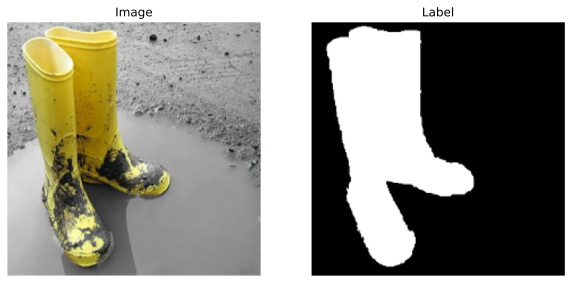

In [10]:
import matplotlib.pyplot as plt

# Take one batch from the dataset
for data, label in train_ds.take(1):  # Take 1 batch from the dataset
    # data and label are tensors; you can convert them to numpy arrays if needed
    image = data[0].numpy()  # Assuming the batch size is at least 1
    label_image = label[0].numpy()

    # Plot the image and its corresponding label
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot original image
    ax[0].imshow(tf.squeeze(image))
    ax[0].set_title("Image")
    ax[0].axis('off')

    # Plot label image
    ax[1].imshow(tf.squeeze(label_image),cmap='gray')
    ax[1].set_title("Label")
    ax[1].axis('off')

    plt.show()
    break  # We only want to show one example


In [11]:
quicksal = QUICKSAL()
quicksal.summary()

Model: "QUICKSAL"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ QUICKSAL_encoder    │ [(None, 56, 56,   │  1,843,424 │ Conv1[0][0]       │
│ (QUICKSAL_encoder)  │ 24), (None, 28,   │            │                   │
│                     │ 28, 32), (None,   │            │                   │
│                     │ 14, 14, 96),      │            │                   │
│                     │ (None, 7, 7,      │            │                   │
│                     │ 320)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ QUICKSAL_decoder    │ (None, 224, 224,  │  1,829,888 │ Conv1[0][0],      │
│ (QUICKSAL_decoder)  │ 16)               │            │ QUICKSAL_encoder… │
│                     │                   │            │ QUICKSAL_encoder… │
│                     │                   │            │ QUICKSAL_encoder… │
│                     │                   │            │ QUICKSAL_encoder… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convf1              │ (None, 224, 224,  │      1,152 │ QUICKSAL_decoder… │
│ (Conv2DTranspose)   │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convf2              │ (None, 224, 224,  │         72 │ Convf1[0][0]      │
│ (Conv2DTranspose)   │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,675,400 (14.02 MB)

 Trainable params: 3,614,504 (13.79 MB)

 Non-trainable params: 60,896 (237.88 KB)

In [12]:
quicksal.compile(
    loss = 'mae',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['mae']
)

In [ ]:
# quicksal.predict(val_data_ds)

In [13]:
quicksal.evaluate(val_ds)

2025-04-28 11:42:47.659566: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 578027520 exceeds 10% of free system memory.
2025-04-28 11:42:48.773704: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1541406720 exceeds 10% of free system memory.


 1/32 ━━━━━━━━━━━━━━━━━━━━ 4:08 8s/step - loss: 56.2382 - mae: 56.2382

2025-04-28 11:42:51.999840: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 578027520 exceeds 10% of free system memory.
2025-04-28 11:42:53.037007: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1541406720 exceeds 10% of free system memory.


 2/32 ━━━━━━━━━━━━━━━━━━━━ 2:01 4s/step - loss: 56.6573 - mae: 56.6573

2025-04-28 11:42:55.987788: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 578027520 exceeds 10% of free system memory.


32/32 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - loss: 58.4125 - mae: 58.4125


[57.992427825927734, 57.992427825927734]

**12. Running a trial fit() for 1 epoch**

In [ ]:
# history = quicksal.fit(train_ds,
#                       epochs = 1,
#                       validation_data = val_ds
# )

  6/250 ━━━━━━━━━━━━━━━━━━━━ 1:59:45 29s/step - loss: 54.2748 - mae: 54.2748

**Conclusion:**
* Estimated time for 1 epoch of training on CPU: Ryzen 7 5700 is 2hrs which is not very optimistic, hence we shall use google colab for GPU access to train this model.

***-- CONTD IN NEXT NOTEBOOK --***